# First try

In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
n_assets = 10  # dimension of x-vector
n_periods = 13  # 1 ... T, T - n_periods

In [41]:
mean = 0  # like in paper
var = 0.1  # like in paper

return_matrix = np.ones((n_periods, n_assets)) + np.random.normal(loc = mean, scale = var, size = (n_periods, n_assets))
assert(return_matrix.shape == (n_periods, n_assets))
assert(len(return_matrix[:, 0]) == n_periods)
assert(len(return_matrix[0, :]) == n_assets)

In [42]:
# (N periods) x (N assets)
return_matrix.shape
assert return_matrix.shape[0] == n_periods
assert return_matrix.shape[1] == n_assets

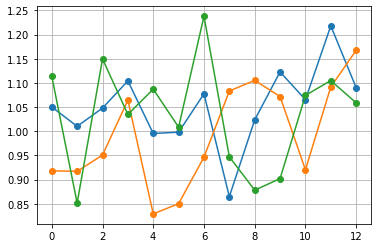

In [43]:
assets = [0, 1, 2]
for ass in assets:
    plt.plot(return_matrix[:, ass], marker = 'o')
plt.grid()

In [44]:
def compute_gradient_component(x, return_matrix, index):
    # R --> (N periods) x (N assets)
    n_periods = return_matrix.shape[0]
    n_assets = return_matrix.shape[1]

    # derive the derivative manually -->
    # here we calculate the formula for the derivative
    # with respect to component x[index]
    res = 0
    for i in range(n_periods):
        r_i = return_matrix[i]
        
        assert len(r_i) == len(x)
        assert len(r_i) == n_assets

        dot_prod = np.dot(r_i, x)
        eps_emergency = 0

        if dot_prod == 0:
            print(f'Zero dot product in compute_gradient_component!!!')
            eps_emergency = 0.001 

        res += (1 / (np.dot(r_i, x) + eps_emergency)) * r_i[index]
    return -res


def compute_gradient(x, return_matrix):
    x_size = x.shape[0]
    res = []
    # For each component of vector "x"
    # calculate gradient
    for i in range(x_size):
        res.append(compute_gradient_component(x, return_matrix, i))
    return np.array(res)
    

def satisfies_stopping_condition(x):
    return False  # Dont know how to implement yet


def calculate_objective(x, return_matrix):
    n_periods = return_matrix.shape[0]
    # n_assets = return_matrix.shape[1]

    ln_dot_products = []
    for i in range(n_periods):
        r_i = return_matrix[i]
        assert(len(r_i) == len(x))

        dot_product = np.dot(r_i, x)
        eps_emergency = 0
        if dot_product == 0:
            print(f'Dot product in objective func == 0! (log() bad!)')
            eps_emergency = 0.001
        ln_dot_products.append(np.log(dot_product + eps_emergency))
    return -np.sum(ln_dot_products)

In [52]:
def frank_wolfe(return_matrix, n_iterations):
    # n_periods = return_matrix.shape[0]
    n_assets = return_matrix.shape[1]
    
    
    # Our solution is a vector x, |x| = n_assets - 
    # investment distribution
    # We pick initial approximation for x - any
    # simplex vertex
    vertex_to_start = 1
    assert vertex_to_start < n_assets, print('Pick another initial approximation')
    x = np.zeros(n_assets)
    x[vertex_to_start] = 1  # initial approximation - all money to one asset

    objective_values = [calculate_objective(x, return_matrix)]  # objective function

    for k in range(1, n_iterations):
        # Compute gradient of objective function
        grad_vector = compute_gradient(x, return_matrix)
        assert(grad_vector.shape[0] == len(x))

        # FW for simplex problem --> minimum of linear
        # function will be reached on the vertex of the simplex
        # Here we search for index with minimum gradient
        # component
        min_index = np.argmin(grad_vector)
        assert grad_vector[min_index] <= 0, print(f'Minimum of gradient vector is positive')
        
        # x_k^ = e_ik from lectures - direction where to go
        xk_hat = np.zeros(n_assets)
        assert(len(xk_hat) == len(grad_vector))
        xk_hat[min_index] = 1

        if satisfies_stopping_condition(xk_hat):
            print(f'Satisfied exiting condition')
            break
        else:
            learning_rate = 2 / (k + 1)
            x = x + learning_rate * (xk_hat - x)
            objective_values.append(calculate_objective(x, return_matrix))  # objective function

    print(f'Reached limit of iterations')
    return x, objective_values

In [53]:
investment_distribution, objective_func = frank_wolfe(
    return_matrix = return_matrix,
    n_iterations = 100
)

Reached limit of iterations


In [54]:
investment_distribution

array([9.99801980e-01, 1.98019802e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

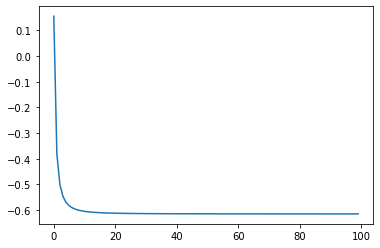

In [57]:
plt.plot(objective_func)